In [327]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [328]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 2))
T = X@np.array([[3.2],[-5]]) + np.random.normal(size=(N, 1), scale=5.5)
T.shape, X.shape

((200, 1), (200, 2))

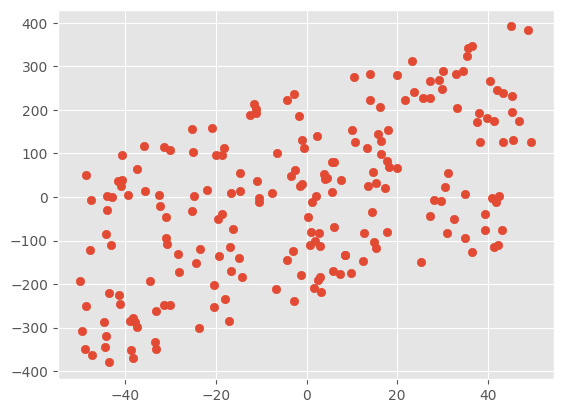

In [329]:
plt.scatter(X[:,:1],T)

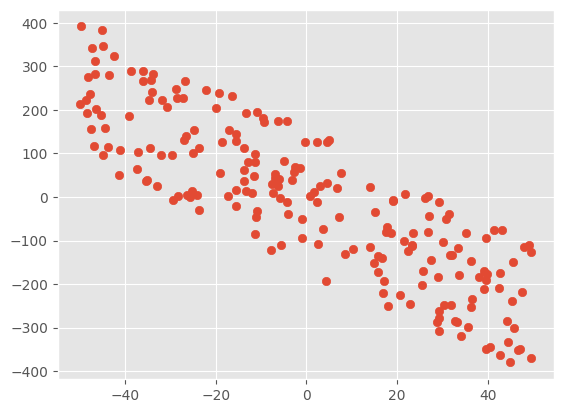

In [330]:
plt.scatter(X[:,1],T)

In [331]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) - (0.5 * (1/(std**2))* (x-mu)**2)

In [332]:
class VIModule(torch.nn.Module) :
	"""
	A mixin class to attach loss functions to layer. This is usefull when doing variational inference with deep learning.
	
	inspired from: Jospin et al. 2022, 10.1109/MCI.2022.3155327
	"""
	
	def __init__(self, *args, **kwargs) :
		super().__init__(*args, **kwargs)
		
		self._internal_losses = []
		self.loss_scale_factor = 1
		
	def add_loss(self, func) :
		self._internal_losses.append(func)
		
	def eval_losses(self) :
		t_loss = 0
		
		for l in self._internal_losses :
			t_loss = t_loss + l()
			
		return t_loss
	
	def eval_all_losses(self) :
		
		t_loss = self.eval_losses()*self.loss_scale_factor
		
        # add the losses that are contained in this module's submodules (if they are VIModules)
		for m in self.children() :
			if isinstance(m, VIModule) :
				t_loss = t_loss + m.eval_all_losses()*self.loss_scale_factor
				
		return t_loss
      


class MCElbo(VIModule):
    def __init__(self,
                 in_features,
                 out_features,
                 n_latent:int = 100,
                 has_bias:bool = False):
        super(MCElbo, self).__init__()
        self.n_latent = n_latent # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.in_features = in_features
        self.out_features = out_features
        
        #The parameters we adjust during training.
        self.weights_m = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        self.weights_s = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_weights_m = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.prior_weights_s = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.likelihood_s = Variable(torch.FloatTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_weights_s.data.fill_(1.0)
        self.prior_weights_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        self.add_loss(self.compute_internal_KL_div_weights)

        # Bias
        self.has_bias = has_bias

        if has_bias:
            self.bias_m = torch.nn.Parameter(torch.randn(out_features), requires_grad=True)
            self.bias_s = torch.nn.Parameter(torch.randn(out_features), requires_grad=True)

            #create holders
            self.prior_bias_m = Variable(torch.randn(out_features), requires_grad=False)
            self.prior_bias_s = Variable(torch.randn(out_features), requires_grad=False)
            
            #Set the prior moments.
            self.prior_bias_m.data.fill_(0.0)
            self.prior_weights_s.data.fill_(1.0)

            self.add_loss(self.compute_internal_KL_div_bias)
     
    
    def sample_weights(self):
        eps = np.random.normal(size=(self.n_latent,self.in_features,self.out_features))
        eps = Variable(torch.FloatTensor(eps))

        self.w_noise_weights = eps
        self.sampled_weights = (eps*self.softplus(self.weights_s)).add(self.weights_m) 
    

    def sample_biases(self):
        eps = np.random.normal(size=(self.n_latent,self.out_features))
        eps = Variable(torch.FloatTensor(eps))

        self.w_noise_biases = eps
        self.sampled_biases = (eps*self.softplus(self.bias_s)).add(self.bias_m) 
    
    
    def sample_all_parameters(self):
        self.sample_weights()

        if self.has_bias:
            self.sample_biases()

    
    def forward(self,x):
        self.sample_all_parameters()
        preds = torch.einsum("ij,kjl->kil",x,self.sampled_weights)
        return preds

    
    def compute_likelihood(self,preds,labels):
        likelihood = torch.mean(torch.sum(log_norm(labels, preds, self.likelihood_s), 0))
        return likelihood
    

    def compute_internal_KL_div_weights(self):
        q_likelihood = log_norm(self.sampled_weights, self.weights_m, self.softplus(self.weights_s))
        q_likelihood = torch.mean(q_likelihood)

        prior = log_norm(self.sampled_weights, self.prior_weights_m, self.softplus(self.prior_weights_s))
        prior = torch.mean(prior)

        return q_likelihood - prior
    

    def compute_internal_KL_div_bias(self):
        q_likelihood = log_norm(self.sampled_biases, self.bias_m, self.softplus(self.bias_s))
        q_likelihood = torch.mean(q_likelihood)

        prior = log_norm(self.sampled_biases, self.prior_bias_m, self.prior_bias_s)
        prior = torch.mean(prior)

        return q_likelihood - prior

In [333]:
x = torch.randn(10,2)
z = torch.randn(5,2,1)
res = torch.einsum("ij,kjl->kil",x,z)

for k in range(z.size(0)):
    for i in range(x.size(0)):
        res_man = x[i] @ z[k]
        assert torch.allclose(res[k,i],res_man)



In [334]:
c = MCElbo(2,1,has_bias=True)
optimizer = torch.optim.Adam(c.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
t = Variable(torch.Tensor(T), requires_grad=False)

for i in range(3000):
    preds = c.forward(x)
    loss = 0

    loss -= c.compute_likelihood(preds,t)
    loss += c.eval_all_losses()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 250 ==0:
        print(c.weights_m.data.numpy(), (c.softplus(c.weights_s).data**2).numpy())

[[-0.5226401]
 [ 0.2703182]] [[0.1190998 ]
 [0.19535023]]
[[ 3.2120726]
 [-5.00392  ]] [[0.00028513]
 [0.00037881]]
[[ 3.2132585]
 [-5.0044665]] [[0.00019749]
 [0.00022306]]
[[ 3.2130702]
 [-5.00384  ]] [[0.00018711]
 [0.00018673]]
[[ 3.2131824]
 [-5.005233 ]] [[0.000179  ]
 [0.00017725]]
[[ 3.212628]
 [-5.004261]] [[0.00017864]
 [0.00017201]]
[[ 3.2125893]
 [-5.0036664]] [[0.00018281]
 [0.00017278]]
[[ 3.212171 ]
 [-5.0045915]] [[0.00018786]
 [0.00017493]]
[[ 3.2127745]
 [-5.0043483]] [[0.00018664]
 [0.00017365]]
[[ 3.2144737]
 [-5.003169 ]] [[0.0001864 ]
 [0.00017311]]
[[ 3.211451]
 [-5.004107]] [[0.00018258]
 [0.00017551]]
[[ 3.2125895]
 [-5.0029087]] [[0.00018587]
 [0.00017162]]


In [335]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**-1
analytical_posterior_var, c.softplus(c.weights_s).data.numpy()**2

(array([[ 0.00018401, -0.00334644],
        [-0.00334644,  0.00017429]]),
 array([[0.00018364],
        [0.00017372]], dtype=float32))

In [336]:
X.T @ T

array([[ 573466.12631841],
       [-897600.88667699]])

In [337]:
analytical_posterior_mean = analytical_posterior_var@(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean, c.weights_m.data.numpy()

(array([[102.78372733],
        [-68.61485057]]),
 array([[ 3.212183 ],
        [-5.0034647]], dtype=float32))

In [338]:
analytical_posterior_mean.shape

(2, 1)

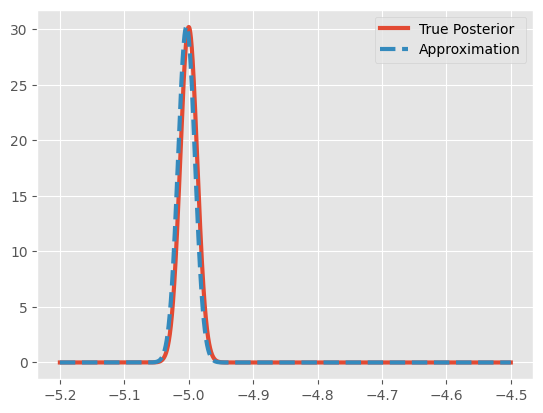

In [339]:
from scipy.stats import norm
param_in, param_out = 1,0
xn = np.arange(-5.2, -4.5, 0.0001)
true_dist = norm(loc = -5, 
                 scale =(analytical_posterior_var[param_in, param_in])**0.5)
q_dist = norm(loc = c.weights_m[param_in, param_out].data.numpy(), scale = c.softplus(c.weights_s[param_in, param_out]).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()

In [340]:
c.bias_m.data.numpy(),c.softplus(c.bias_s).data.numpy()

(array([0.0196158], dtype=float32), array([0.7757424], dtype=float32))

In [341]:
yn

array([4.41002101e-049, 4.94611299e-049, 5.54705522e-049, ...,
       1.80071979e-310, 1.35174238e-310, 1.01465128e-310])